[*********************100%***********************]  1 of 1 completed



Training LSTM model...
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - loss: 0.0283 - val_loss: 8.8768e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 8.1656e-04 - val_loss: 0.0011
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 5.8439e-04 - val_loss: 5.3713e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.6537e-04 - val_loss: 4.9748e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 4.7499e-04 - val_loss: 6.0183e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.3730e-04 - val_loss: 5.3933e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.5072e-04 - val_loss: 4.4136e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.4748e-04 - val_loss: 4.1525e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 3.4776e-04 - val_loss: 5.6710e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.6801e-04 - val_loss: 4.7694e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 

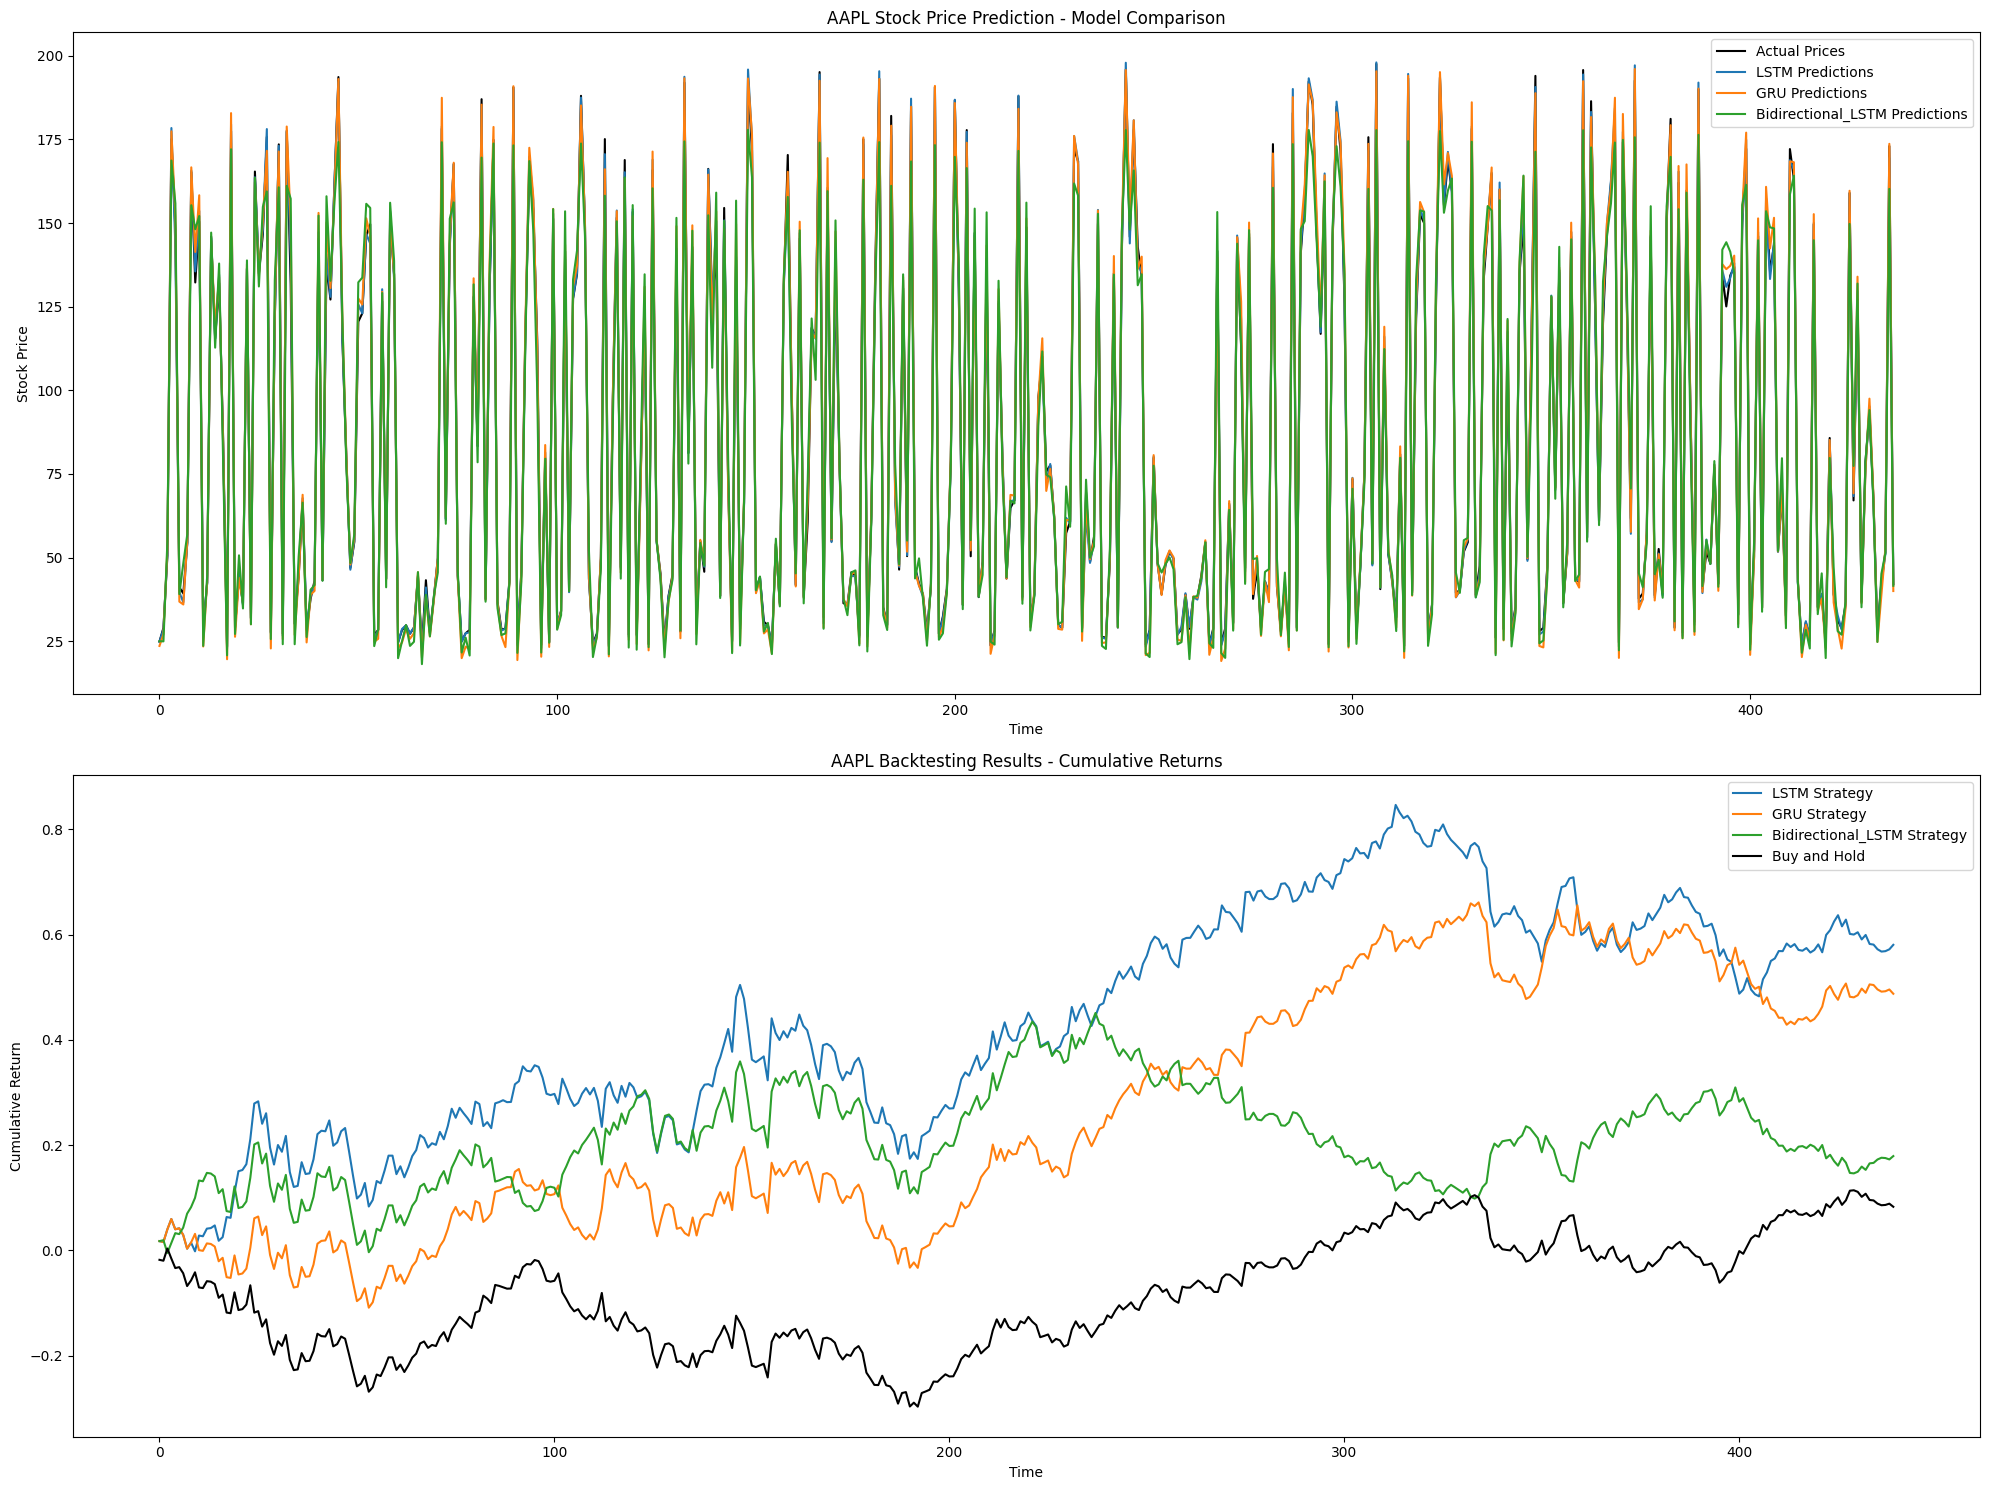

In [5]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential, load_model,Model
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# Data Collection
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Data Preprocessing
def preprocess_data(data, sequence_length):
    # Calculate additional features
    data['Daily_Return'] = data['Close'].pct_change()
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['RSI'] = calculate_rsi(data['Close'], window=14)

    # Drop NaN values
    data = data.dropna()

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data.iloc[i:(i + sequence_length)].values)
        y.append(scaled_data.iloc[i + sequence_length]['Close'])

    X, y = np.array(X), np.array(y)

    return X, y, scaler

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Model Creation
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)
    x = LSTM(50, return_sequences=False)(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(50, return_sequences=True)(inputs)
    x = GRU(50, return_sequences=False)(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_bidirectional_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(50, return_sequences=False))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Evaluation function
def evaluate_model(model, X_test, y_test, scaler, data_columns):
    predictions = model.predict(X_test)

    # Inverse transform predictions and actual values
    pred_prices = np.zeros((len(predictions), len(data_columns)))
    pred_prices[:, data_columns.get_loc('Close')] = predictions.flatten()
    pred_prices = scaler.inverse_transform(pred_prices)[:, data_columns.get_loc('Close')]

    actual_prices = np.zeros((len(y_test), len(data_columns)))
    actual_prices[:, data_columns.get_loc('Close')] = y_test
    actual_prices = scaler.inverse_transform(actual_prices)[:, data_columns.get_loc('Close')]

    mse = mean_squared_error(actual_prices, pred_prices)
    r2 = r2_score(actual_prices, pred_prices)

    return mse, r2, pred_prices, actual_prices

# Model persistence functions
def save_model(model, name):
    if not os.path.exists('models'):
        os.makedirs('models')
    model.save(f'models/{name}.keras')
    print(f"Model saved as models/{name}.keras")

def load_saved_model(name, X_shape):
    model = load_model(f'models/{name}.keras')
    # Recompile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Call the model once to build the metrics
    dummy_data = np.zeros((1, X_shape[1], X_shape[2]))
    model.predict(dummy_data)
    return model


# New function for backtesting
def backtest(data, model, scaler, sequence_length, start_date, end_date):
    backtesting_data = data.loc[start_date:end_date]
    predictions = []
    actual_prices = []

    for i in range(len(backtesting_data) - sequence_length):
        # Prepare input sequence
        input_sequence = backtesting_data.iloc[i:i+sequence_length]
        input_sequence = pd.DataFrame(scaler.transform(input_sequence), columns=input_sequence.columns)
        input_sequence = np.expand_dims(input_sequence.values, axis=0)

        # Make prediction
        prediction = model.predict(input_sequence)

        # Inverse transform prediction
        pred_price = np.zeros((1, len(data.columns)))
        pred_price[0, data.columns.get_loc('Close')] = prediction[0, 0]
        pred_price = scaler.inverse_transform(pred_price)[0, data.columns.get_loc('Close')]

        predictions.append(pred_price)
        actual_prices.append(backtesting_data.iloc[i+sequence_length]['Close'])

    return np.array(predictions), np.array(actual_prices)

# New function to calculate trading performance
def calculate_performance(predictions, actual_prices):
    returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
    predicted_returns = (predictions[1:] - actual_prices[:-1]) / actual_prices[:-1]

    # Calculate strategy returns (long when predicted return is positive, short otherwise)
    strategy_returns = np.where(predicted_returns > 0, returns, -returns)

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns) - 1
    cumulative_strategy_returns = np.cumprod(1 + strategy_returns) - 1

    # Calculate Sharpe ratio (assuming 252 trading days per year and risk-free rate of 0)
    sharpe_ratio = np.sqrt(252) * np.mean(strategy_returns) / np.std(strategy_returns)

    return {
        'Cumulative Return': cumulative_strategy_returns[-1],
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Returns': cumulative_returns,
        'Cumulative Strategy Returns': cumulative_strategy_returns
    }

# Main execution
if __name__ == "__main__":
    # Parameters
    ticker = "AAPL"
    start_date = "2015-01-01"
    end_date = "2023-12-31"
    sequence_length = 60
    backtesting_start = "2022-01-01"

    # Get and preprocess data
    data = get_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model architectures
    model_architectures = {
        "LSTM": create_lstm_model,
        "GRU": create_gru_model,
        "Bidirectional_LSTM": create_bidirectional_lstm_model
    }

    results = {}
    backtesting_results = {}

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=10,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
        verbose=1
    )

    for name, create_func in model_architectures.items():
        print(f"\nTraining {name} model...")

        # Check if a saved model exists
        if os.path.exists(f'models/{name}.h5'):
            print(f"Loading saved {name} model...")
            model = load_saved_model(name)
        else:
            model = create_func(input_shape=(X.shape[1], X.shape[2]))
            history = model.fit(
                X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_split=0.1,
                verbose=1,
                callbacks=[early_stopping]  # Add early stopping callback
            )
            save_model(model, name)

        mse, r2, predictions, actual = evaluate_model(model, X_test, y_test, scaler, data.columns)
        results[name] = {"mse": mse, "r2": r2, "predictions": predictions}

        print(f"{name} - Mean Squared Error: {mse}")
        print(f"{name} - R-squared Score: {r2}")

        # Perform backtesting
        backtest_predictions, backtest_actual = backtest(data, model, scaler, sequence_length, backtesting_start, end_date)
        performance = calculate_performance(backtest_predictions, backtest_actual)
        backtesting_results[name] = performance

        print(f"{name} - Backtesting Results:")
        print(f"  Cumulative Return: {performance['Cumulative Return']:.2%}")
        print(f"  Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")

    # Plot results
    plt.figure(figsize=(20, 15))

    # Subplot 1: Model Predictions
    plt.subplot(2, 1, 1)
    plt.plot(actual, label='Actual Prices', color='black')
    for name, result in results.items():
        plt.plot(result['predictions'], label=f'{name} Predictions')
    plt.title(f'{ticker} Stock Price Prediction - Model Comparison')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()

    # Subplot 2: Backtesting Results
    plt.subplot(2, 1, 2)
    for name, result in backtesting_results.items():
        plt.plot(result['Cumulative Strategy Returns'], label=f'{name} Strategy')
    plt.plot(result['Cumulative Returns'], label='Buy and Hold', color='black')
    plt.title(f'{ticker} Backtesting Results - Cumulative Returns')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()

    plt.tight_layout()
    plt.show()